# Welcome to Full Stack Machine Learning's Week 3 Project!

Welcome to the taxi fare prediction project! In this project, you will be taking on the role of a Data Scientist tasked with developing a model that can predict the fare for a taxi ride in New York City. The [dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) we will be using contains records of trips made by yellow and green taxis, as well as records of For-Hire Vehicle (FHV) trips.

As a Data Scientist, your goal will be to use this data to build an accurate model that can predict taxi fares. You will learn how to preprocess the data and train a model. Additionally, you will be introduced to event-driven Machine Learning pipelines and learn how to trigger these pipelines in the cloud using Metaflow.

By the end of this project, you will have gained valuable experience in building and evaluating Machine Learning models for real-world applications, as well as a deeper understanding of how to run pipelines in the cloud.

## Task 0: Install new Metaflow version to use event-triggering features

Run the next cell to update to the latest Metaflow release with event-triggering support. Note you only need to run it one time in the `full-stack-metaflow-corise` environment in your sandbox.

In [1]:
%%capture
! pip install -U metaflow

## Task 1: EDA

You can find the [original `.parquet` file here](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet).

Suggestion: This week is primarily about task 2-3, and 4 if you have time. Don't spend more than an hour on Task 1.

In [2]:
# imports
from metaflow import S3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# configuration
YELLOW = '#FFBC00'
GREEN = '#37795D'
PURPLE = '#5460C0'
BACKGROUND = '#F4EBE6'
colors = [GREEN, PURPLE]
custom_params = {
    'axes.spines.right': False, 'axes.spines.top': False,
    'axes.facecolor':BACKGROUND, 'figure.facecolor': BACKGROUND, 
    'figure.figsize':(8, 8)
}
sns_palette = sns.color_palette(colors, len(colors))
sns.set_theme(style='ticks', rc=custom_params)

In [3]:
# Open a context manager to download data from the cloud.
# s3 = S3(s3root='s3://outerbounds-datasets/taxi')

# Use Metaflow S3 client to get the latest file.
# This file is being updated every hour, simulating the changing, drifting, and sometimes broken nature of production data streams.
# obj = s3.get('latest.parquet')
# The goal is to write a flow that builds and cross-validates a model to predicts the total fare of each taxi rid (row) in the dataset.
# Since the data is changing, Task 2 and 3 asks you to deploy a flow to production via Argo workflows, so your workflow can run automatically when this file changes in S3.

# Load the contents of the parquet file in memory.
# df = pd.read_parquet(obj.path)

# s3.close()

In [22]:
# Open a context manager to download data from the cloud.
with S3(s3root='s3://outerbounds-datasets/taxi') as s3:
    # Use Metaflow S3 client to get the latest file.
    # This file is being updated every hour, simulating the changing, drifting, and sometimes broken nature of production data streams.
    obj = s3.get('latest.parquet')
    # The goal is to write a flow that builds and cross-validates a model to predicts the total fare of each taxi rid (row) in the dataset.
    # Since the data is changing, Task 2 and 3 asks you to deploy a flow to production via Argo workflows, so your workflow can run automatically when this file changes in S3.

    # Load the contents of the parquet file in memory.
    df = pd.read_parquet(obj.path)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
0,2,2023-05-10 08:32:10,2023-05-10 08:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0
1,2,2023-05-10 08:55:08,2023-05-10 09:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,1
2,2,2023-05-10 08:25:04,2023-05-10 08:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0
3,1,2023-05-10 08:03:48,2023-05-10 08:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0
4,2,2023-05-10 08:10:29,2023-05-10 08:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985857 entries, 0 to 3018130
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               985857 non-null  int64         
 1   tpep_pickup_datetime   985857 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  985857 non-null  datetime64[ns]
 3   passenger_count        962773 non-null  float64       
 4   trip_distance          982341 non-null  float64       
 5   RatecodeID             962773 non-null  float64       
 6   store_and_fwd_flag     962773 non-null  object        
 7   PULocationID           985857 non-null  int64         
 8   DOLocationID           985857 non-null  int64         
 9   payment_type           985857 non-null  int64         
 10  fare_amount            985857 non-null  float64       
 11  extra                  985857 non-null  float64       
 12  mta_tax                985857 non-null  flo

In [5]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
count,985857.000000,962773.000000,982341.000000,962773.000000,985857.000000,985857.000000,985857.000000,985857.000000,985857.000000,985857.000000,985857.000000,985857.000000,985857.000000,985857.000000,962773.000000,962773.000000,985857.000000
mean,1.731420,1.388729,3.925292,1.547754,166.001234,163.889659,1.214944,18.916758,1.533514,0.487568,3.337346,0.558845,0.981016,27.568764,2.247207,0.121576,137.805466
std,0.443221,0.919928,237.492628,6.765403,64.247362,70.289709,0.544082,18.729391,1.817667,0.114643,3.918416,2.091812,0.187203,23.132600,0.807435,0.376104,73.279732
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-497.900000,-7.500000,-0.500000,-33.930000,-39.300000,-1.000000,-520.550000,-2.500000,-1.250000,0.000000
25%,1.000000,1.000000,1.080000,1.000000,132.000000,113.000000,1.000000,8.600000,0.000000,0.500000,0.200000,0.000000,1.000000,15.400000,2.500000,0.000000,82.000000
50%,2.000000,1.000000,1.820000,1.000000,162.000000,162.000000,1.000000,12.800000,1.000000,0.500000,2.660000,0.000000,1.000000,20.150000,2.500000,0.000000,138.000000
75%,2.000000,1.000000,3.500000,1.000000,234.000000,234.000000,1.000000,20.500000,2.500000,0.500000,4.140000,0.000000,1.000000,29.120000,2.500000,0.000000,203.000000
max,2.000000,6.000000,225987.370000,99.000000,265.000000,265.000000,4.000000,999.000000,11.250000,53.160000,211.500000,86.550000,1.000000,1000.000000,2.500000,1.250000,260.000000


In [25]:
obviously_bad_data_filters = [

    df.fare_amount > 0,         # fare_amount in US Dollars
    df.trip_distance <= 100,    # trip_distance in miles
    df.trip_distance > 0,

    # TODO: add some logic to filter out what you decide is bad data!
    # TIP: Don't spend too much time on this step for this project though, it practice it is a never-ending process.
    df.extra >= 0,
    df.mta_tax >= 0,
    df.tip_amount >= 0,
    df.total_amount > 0,
    df.airport_fee >= 0,

]

for f in obviously_bad_data_filters:
    df = df[f]

/tmp/ipykernel_27892/3529793544.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[f]


In [26]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
count,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000,939238.000000
mean,1.732880,1.389787,3.609712,1.478817,166.171721,164.034442,1.220316,19.050317,1.598614,0.497294,3.359255,0.565682,0.998318,27.852444,2.299103,0.124083,138.597622
std,0.442456,0.922121,4.668727,6.357307,63.979424,70.215477,0.463267,17.902175,1.813760,0.066714,3.873082,2.077431,0.034403,22.255421,0.679620,0.373775,72.942810
min,1.000000,0.000000,0.010000,1.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.100000,1.000000,132.000000,113.000000,1.000000,8.600000,0.000000,0.500000,1.000000,0.000000,1.000000,15.400000,2.500000,0.000000,83.000000
50%,2.000000,1.000000,1.840000,1.000000,162.000000,162.000000,1.000000,12.800000,1.000000,0.500000,2.660000,0.000000,1.000000,20.150000,2.500000,0.000000,139.000000
75%,2.000000,1.000000,3.530000,1.000000,234.000000,234.000000,1.000000,20.500000,2.500000,0.500000,4.140000,0.000000,1.000000,29.000000,2.500000,0.000000,203.000000
max,2.000000,6.000000,93.050000,99.000000,265.000000,265.000000,4.000000,557.400000,11.250000,53.160000,211.500000,86.550000,1.000000,581.700000,2.500000,1.250000,260.000000


In [27]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
0,2,2023-05-10 08:32:10,2023-05-10 08:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0
1,2,2023-05-10 08:55:08,2023-05-10 09:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,1
2,2,2023-05-10 08:25:04,2023-05-10 08:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0
3,1,2023-05-10 08:03:48,2023-05-10 08:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0
4,2,2023-05-10 08:10:29,2023-05-10 08:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0


In [28]:
print(df.shape)
(df.isna().sum() / df.shape[0]) * 100

(939238, 20)


VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
RatecodeID               0.0
store_and_fwd_flag       0.0
PULocationID             0.0
DOLocationID             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
airport_fee              0.0
hour                     0.0
dtype: float64

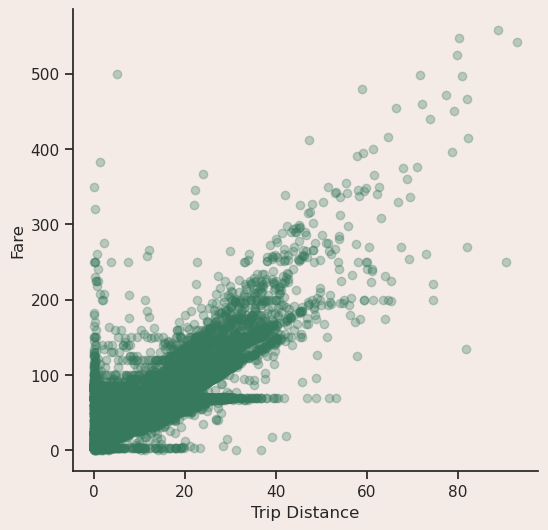

In [29]:
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(df.trip_distance, df.fare_amount, color=GREEN, alpha=0.3)
ax.set_xlabel("Trip Distance")
ax.set_ylabel("Fare");

## Task 2: Write a flow

In this task, you will deploy a workflow to Argo Workflows. The following flow is mostly written for you, minus a few TODO items.

Notice the use of the `@trigger` flow-level decorator.
In this flow, this is telling Argo to listen for events named `s3`, and to trigger a run of the flow when the S3 event is emitted. 
The S3 event your sandbox is listening for are the updates to the `latest.parquet` file mentioned in the comments in [Task 1](#task-1-eda). 

In [31]:
%%writefile ../flows/cloud/event_triggered_linear_regression.py
from metaflow import FlowSpec, step, card, conda_base, current, Parameter, Flow, trigger
from metaflow.cards import Markdown, Table, Image, Artifact

URL = "https://outerbounds-datasets.s3.us-west-2.amazonaws.com/taxi/latest.parquet"
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

@trigger(events=['s3'])
@conda_base(libraries={'pandas': '1.4.2', 'pyarrow': '11.0.0', 'numpy': '1.21.2', 'scikit-learn': '1.1.2', 'py-xgboost': '1.7.4'})
class TaxiFarePrediction(FlowSpec):

    data_url = Parameter("data_url", default=URL)

    def transform_features(self, df):

        # TODO: 
            # Try to complete tasks 2 and 3 with this function doing nothing like it currently is.
            # Understand what is happening.
            # Revisit task 1 and think about what might go in this function.
        df = df.dropna()
        return df

    @step
    def start(self):

        import pandas as pd
        from sklearn.model_selection import train_test_split

        self.df = self.transform_features(pd.read_parquet(self.data_url))

        # NOTE: we are split into training and validation set in the validation step which uses cross_val_score.
        # This is a simple/naive way to do this, and is meant to keep this example simple, to focus learning on deploying Metaflow flows.
        # In practice, you want split time series data in more sophisticated ways and run backtests. 
        self.X = self.df["trip_distance"].values.reshape(-1, 1)
        self.y = self.df["total_amount"].values
        self.next(self.linear_model)

    @step
    def linear_model(self):
        "Fit a single variable, linear model to the data."
        # from sklearn.linear_model import LinearRegression
        from xgboost import XGBRegressor
        # TODO: Play around with the model if you are feeling it.
        # self.model = LinearRegression()
        self.model = XGBRegressor()

        self.next(self.validate)

    def gather_sibling_flow_run_results(self):

        # storage to populate and feed to a Table in a Metaflow card
        rows = []

        # loop through runs of this flow 
        for run in Flow(self.__class__.__name__):
            if run.id != current.run_id:
                if run.successful:
                    icon = "✅" 
                    msg = "OK"
                    score = str(run.data.scores.mean())
                else:
                    icon = "❌"
                    msg = "Error"
                    score = "NA"
                    for step in run:
                        for task in step:
                            if not task.successful:
                                msg = task.stderr
                row = [Markdown(icon), Artifact(run.id), Artifact(run.created_at.strftime(DATETIME_FORMAT)), Artifact(score), Markdown(msg)]
                rows.append(row)
            else:
                rows.append([Markdown("✅"), Artifact(run.id), Artifact(run.created_at.strftime(DATETIME_FORMAT)), Artifact(str(self.scores.mean())), Markdown("This run...")])
        return rows
                
    
    @card(type="corise")
    @step
    def validate(self):
        from sklearn.model_selection import cross_val_score
        self.scores = cross_val_score(self.model, self.X, self.y, cv=5)
        current.card.append(Markdown("# Taxi Fare Prediction Results"))
        current.card.append(Table(self.gather_sibling_flow_run_results(), headers=["Pass/fail", "Run ID", "Created At", "R^2 score", "Stderr"]))
        self.next(self.end)

    @step
    def end(self):
        print("Success!")


if __name__ == "__main__":
    TaxiFarePrediction()

Overwriting ../flows/cloud/event_triggered_linear_regression.py


### Run the Flow

In [32]:
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda run

Metaflow 2.9.1+ob(v1) executing TaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Bootstrapping conda environment...(this could take a few minutes)
2023-05-21 03:33:25.790 Workflow starting (run-id 61), see it in the UI at https://ui-pw-1752302777.outerbounds.dev/TaxiFarePrediction/61
2023-05-21 03:33:26.731 [61/start/208 (pid 29873)] Task is starting.
2023-05-21 03:33:31.940 [61/start/208 (pid 29873)] Task finished successfully.
2023-05-21 03:33:32.902 [61/linear_model/209 (pid 29954)] Task is starting.
2023-05-21 03:33:35.510 [61/linear_model/209 (pid 29954)] Task finished successfully.
2023-05-21 03:33:36.365 [61/validate/210 (pid 30002)] Task is starting.
2023-05-21 03:34:36.503 [61/validate/210 (pid 30002)] Task finished successfully.
2023-05-21 03:34:37.458 [61/end/211 (pid 30064)] Task is starting.
2023-05-21 03:34:38.467 [61/end/211 (pid 30064)] Success!
2023-05-21 03:34:39.197 [61/end/211 (pid 30064)] T

## Task 3: Promote to Production

Once the workflow in the previous section is running and logging results as you like, it is time to deploy this workflow to production, so it can run in the cloud without manually triggering it. 

You can read more in [Metaflow's Argo documentation](https://docs.metaflow.org/production/scheduling-metaflow-flows/scheduling-with-argo-workflows).

### Deploying the workflow to Argo

In [33]:
# NOTE: If you run from this from the terminal you may need to adjust the path to the flow file, depending on where you saved it - what comes after %%writefile? 
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda --with retry argo-workflows create 

Metaflow 2.9.1+ob(v1) executing TaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Deploying taxifareprediction to Argo Workflows...

The namespace of this production flow is
    production:taxifareprediction-0-ouyj
To analyze results of this production flow add this line in your notebooks:
    namespace("production:taxifareprediction-0-ouyj")
If you want to authorize other people to deploy new versions of this flow to Argo Workflows, they need to call
    argo-workflows create --authorize taxifareprediction-0-ouyj
when deploying this flow to Argo Workflows for the first time.
See "Organizing Results" at https://docs.metaflow.org/ for more information about production tokens.

Bootstrapping conda environment...(this could take a few minutes)
Workflow taxifareprediction for flow TaxiFarePrediction pushed to Argo Workflows successfully.

Note that the flow was deployed with a modified name due to Kubernetes naming 

Now, go to the Argo deployment attached to your sandbox by finding your ID from the URL in your browser.

Your sandbox has a unique ID, visible in the URL with this pattern.
```
https://vs-<YOUR ID>.outerbounds.dev/<DELETE EVERYTHING AFTER THIS>
```

Remove the `vs` part in front, and everything after `.dev`, then navigate to your sandboxes Argo deployment at:
```
https://argo-<YOUR ID>.outerbounds.dev/
```

Navigating to the "Workflow Templates" section of the Argo UI, you should find your workflow has been deployed:

<img src="../img/argo-workflow-template.png" width="1200px">

### Manually trigger the workflow

In [34]:
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda argo-workflows trigger

Metaflow 2.9.1+ob(v1) executing TaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Workflow taxifareprediction triggered on Argo Workflows (run-id argo-taxifareprediction-xtrhf).
See the run in the UI at https://ui-pw-1752302777.outerbounds.dev/TaxiFarePrediction/argo-taxifareprediction-xtrhf


After triggering the worfklow, return to your Argo dashboard and navigate to the `Workflows` section to see your flow executing:

<img src="../img/argo-workflow.png" width="1200px">

### How is the flow "automatically" triggered? 

In the previous section, you manually triggered the deployed flow using a Metaflow command. 
So how will it run without that manual trigger in production? 

1. There is a script running in the background in your sandbox that looks at the `latest.parquet` file in S3 and emits an `S3` when it has changed since the last `TaxiFarePrediction` flow run was created. As mentioned earlier, the file is being updated every hour, time shifting the [NYC taxi data stream from January 2023](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet).
2. When the events are emitted, the same thing happens as the command you ran in [the previous section](#manually-trigger-the-workflow).

## Bonus Task 4: Handle Failures! 


If you deployed the flow in the previous task, excellent job! 
Now it is time to harden the workflow so it is robust to the vagaries of real world data.

Specifically, at some point we will intentionally corrupt some of the training data, to simulate a common real world occurence.

Can you,
1. Figure out what is happening in the new data that is causing an error?
2. Add a few lines of code to your `TaxiFarePrediction` flow's `start` step that will make your flow robust to this kind of data quality issue?
3. How would you refactor the `TaxiFarePrediction` to use the decorators you learned in this week's lesson, such as `@catch`, `@retry`, etc.? 

(Optional) TODO: Write a report of your findings to these questions.
(Optional) TODO: Update your production deployment of `TaxiFarePrediction` with the new approach(es).

In [35]:
%%writefile ../flows/cloud/new_event_triggered_linear_regression.py
from metaflow import FlowSpec, step, card, conda_base, current, Parameter, Flow, trigger
from metaflow.cards import Markdown, Table, Image, Artifact

URL = "https://outerbounds-datasets.s3.us-west-2.amazonaws.com/taxi/latest.parquet"
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

@trigger(events=['s3'])
@conda_base(libraries={'pandas': '1.4.2', 'pyarrow': '11.0.0', 'numpy': '1.21.2', 'scikit-learn': '1.1.2', 'py-xgboost': '1.7.4'})
class NewTaxiFarePrediction(FlowSpec):

    data_url = Parameter("data_url", default=URL)

    def transform_features(self, df):

        # TODO: 
            # Try to complete tasks 2 and 3 with this function doing nothing like it currently is.
            # Understand what is happening.
            # Revisit task 1 and think about what might go in this function.

        obviously_bad_data_filters = [

            df.fare_amount > 0,         # fare_amount in US Dollars
            df.trip_distance <= 100,    # trip_distance in miles
            df.trip_distance > 0,

            # TODO: add some logic to filter out what you decide is bad data!
            # TIP: Don't spend too much time on this step for this project though, it practice it is a never-ending process.
            df.extra >= 0,
            df.mta_tax >= 0,
            df.tip_amount >= 0,
            df.total_amount > 0,
            df.airport_fee >= 0,

        ]

        for f in obviously_bad_data_filters:
            df = df[f]
        df = df.dropna()
        return df

    @retry(times=2)  # maybe a read error
    @step
    def start(self):

        import pandas as pd
        from sklearn.model_selection import train_test_split

        self.df = self.transform_features(pd.read_parquet(self.data_url))

        # NOTE: we are split into training and validation set in the validation step which uses cross_val_score.
        # This is a simple/naive way to do this, and is meant to keep this example simple, to focus learning on deploying Metaflow flows.
        # In practice, you want split time series data in more sophisticated ways and run backtests. 
        self.X = self.df["trip_distance"].values.reshape(-1, 1)
        self.y = self.df["total_amount"].values
        self.next(self.linear_model)

    @step
    def linear_model(self):
        "Fit a single variable, linear model to the data."
        # from sklearn.linear_model import LinearRegression
        from xgboost import XGBRegressor
        # TODO: Play around with the model if you are feeling it.
        # self.model = LinearRegression()
        self.model = XGBRegressor()

        self.next(self.validate)

    def gather_sibling_flow_run_results(self):

        # storage to populate and feed to a Table in a Metaflow card
        rows = []

        # loop through runs of this flow 
        for run in Flow(self.__class__.__name__):
            if run.id != current.run_id:
                if run.successful:
                    icon = "✅" 
                    msg = "OK"
                    score = str(run.data.scores.mean())
                else:
                    icon = "❌"
                    msg = "Error"
                    score = "NA"
                    for step in run:
                        for task in step:
                            if not task.successful:
                                msg = task.stderr
                row = [Markdown(icon), Artifact(run.id), Artifact(run.created_at.strftime(DATETIME_FORMAT)), Artifact(score), Markdown(msg)]
                rows.append(row)
            else:
                rows.append([Markdown("✅"), Artifact(run.id), Artifact(run.created_at.strftime(DATETIME_FORMAT)), Artifact(str(self.scores.mean())), Markdown("This run...")])
        return rows
                
    
    @card(type="corise")
    @step
    def validate(self):
        from sklearn.model_selection import cross_val_score
        self.scores = cross_val_score(self.model, self.X, self.y, cv=5)
        current.card.append(Markdown("# Taxi Fare Prediction Results"))
        current.card.append(Table(self.gather_sibling_flow_run_results(), headers=["Pass/fail", "Run ID", "Created At", "R^2 score", "Stderr"]))
        self.next(self.end)

    @step
    def end(self):
        print("Success!")


if __name__ == "__main__":
    NewTaxiFarePrediction()

Writing ../flows/cloud/new_event_triggered_linear_regression.py


In [36]:
! python ../flows/cloud/new_event_triggered_linear_regression.py --environment=conda run

Metaflow 2.9.1+ob(v1) executing NewTaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Bootstrapping conda environment...(this could take a few minutes)
2023-05-21 03:52:01.698 Workflow starting (run-id 63), see it in the UI at https://ui-pw-1752302777.outerbounds.dev/NewTaxiFarePrediction/63
2023-05-21 03:52:02.686 [63/start/215 (pid 30655)] Task is starting.
2023-05-21 03:52:13.469 [63/start/215 (pid 30655)] Task finished successfully.
2023-05-21 03:52:14.369 [63/linear_model/216 (pid 30763)] Task is starting.
2023-05-21 03:52:17.139 [63/linear_model/216 (pid 30763)] Task finished successfully.
2023-05-21 03:52:18.102 [63/validate/217 (pid 30817)] Task is starting.
2023-05-21 03:53:16.050 [63/validate/217 (pid 30817)] Task finished successfully.
2023-05-21 03:53:16.926 [63/end/218 (pid 30895)] Task is starting.
2023-05-21 03:53:17.891 [63/end/218 (pid 30895)] Success!
2023-05-21 03:53:18.658 [63/end/218 (pid 308